In [1]:
#!pip install scikit-learn
#!pip install tensorflow
#!pip install tensorflow-gpu


In [2]:
import numpy as np

In [3]:
import random
import os
import numpy as np

# crossValidationDataPaths=['NORMALIZED/NumericalData/ML/Training/RightHand','NORMALIZED/NumericalData/ML/Training/LeftHand']
# testPaths=['NORMALIZED/NumericalData/ML/Test/RightHand','NORMALIZED/NumericalData/ML/Test/LeftHand']

crossValidationDataPaths=['NORMALIZED_ORIGINAL/NumericalData/ML/Training/RightHand','NORMALIZED_ORIGINAL/NumericalData/ML/Training/LeftHand_NO_FLIP']
testPaths=['NORMALIZED_ORIGINAL/NumericalData/ML/Test/RightHand','NORMALIZED_ORIGINAL/NumericalData/ML/Test/LeftHand_NO_FLIP']





ml_instances_paths=[]
for path in crossValidationDataPaths:
    #print(path)
    classFolders= os.listdir(path)
    for classFolder in classFolders:
        classFolder_path=f'{path}/{classFolder}'
        classTrials =os.listdir(classFolder_path)
        for trial in classTrials:
            trialPath =f'{classFolder_path}/{trial}'
            #print(trialPath)
            ml_instances_paths.append(trialPath)
            


#randomize the list
random.shuffle(ml_instances_paths)



x_shape =[]
y_shape =[]
for ml_instances_path in ml_instances_paths:
    label = ml_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    y_shape.append(int(label))
    npy =np.load(ml_instances_path)
    npy = npy*100
  
    npy_matrix=npy.reshape(-1,1629)
   
    # npy_matrix=extractPoseHand(npy)
    x_shape.append(npy_matrix)    

test_instances_paths=[]
for path in testPaths:
    #print(path)
    testFolders= os.listdir(path)
    for testFolder in testFolders:
        testFolder_path=f'{path}/{testFolder}'
        testTrials =os.listdir(testFolder_path)
        for trial in testTrials:
            trialPath =f'{testFolder_path}/{trial}'
            #print(trialPath)
            test_instances_paths.append(trialPath)


test_x_shape =[]
test_y_shape =[]
for test_instances_path in test_instances_paths:
    label = test_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    test_y_shape.append(int(label))
    npy =np.load(test_instances_path)
    npy=npy*100
    npy_matrix=npy.reshape(-1,1629)

    # npy_matrix=extractPoseHand(npy)
    
    test_x_shape.append(npy_matrix)    


In [4]:
# print(x_shape.shape)
# print(y_shape.shape)

In [5]:
# print(test_x_shape.shape)
# print(test_y_shape.shape)


In [6]:
print('hello')

hello


In [7]:
# training the total data
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Flatten, Dense,Input,  Dropout, BatchNormalization, GRU, Attention,Concatenate, Conv1D, Masking, Embedding
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.optimizers import Adam
import os

epochs = 200
batch_size = 32 # 64
NO_CLASSES = 60 #Changes according to no of class
MAX_FRMAE = 164

learning_rate = 0.00003
input_shape = (MAX_FRMAE,1629)



log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

print(y_shape)
#y_onehot = to_categorical(y_shape).astype(int)
label_encoder=LabelEncoder()
y_encoded =label_encoder.fit_transform(y_shape)
y_onehot =to_categorical(y_encoded,num_classes=NO_CLASSES)
print(len(y_onehot))



all_accuracies = []
x_shapeML = np.array(x_shape) #.astype(int)
x_train=x_shapeML
y_train =y_onehot

test_x_shapeML = np.array(test_x_shape) #.astype(int)
x_val=test_x_shapeML

#y_val = to_categorical(test_y_shape).astype(int)
y_encoded =label_encoder.fit_transform(test_y_shape)
y_val =to_categorical(y_encoded,num_classes=NO_CLASSES)


print('Train shape: ',x_train.shape, y_train.shape,'Test Shape: ', x_val.shape, y_val.shape)




2023-12-30 17:13:20.182684: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-30 17:13:20.305815: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-30 17:13:20.305855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-30 17:13:20.325956: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-30 17:13:20.368229: I tensorflow/core/platform/cpu_feature_guar

[18, 56, 45, 13, 53, 5, 28, 8, 50, 2, 50, 11, 29, 9, 4, 3, 0, 2, 37, 16, 48, 18, 9, 4, 28, 44, 12, 51, 37, 18, 56, 44, 7, 29, 45, 35, 3, 16, 7, 52, 45, 1, 42, 18, 29, 57, 27, 39, 40, 33, 49, 39, 55, 37, 48, 44, 57, 29, 48, 47, 59, 45, 48, 3, 39, 9, 54, 50, 46, 41, 50, 19, 23, 51, 52, 35, 22, 0, 37, 27, 38, 38, 52, 36, 58, 23, 3, 12, 32, 48, 46, 59, 19, 53, 12, 8, 24, 52, 21, 33, 13, 41, 45, 48, 7, 58, 28, 5, 45, 29, 0, 47, 13, 48, 56, 36, 22, 23, 51, 40, 23, 57, 42, 16, 10, 16, 49, 16, 24, 8, 51, 47, 15, 35, 37, 30, 52, 54, 28, 17, 17, 14, 16, 56, 29, 19, 49, 25, 47, 23, 50, 43, 20, 26, 10, 11, 48, 11, 59, 37, 27, 0, 1, 36, 33, 24, 13, 20, 30, 26, 25, 38, 55, 25, 37, 13, 43, 20, 11, 26, 58, 55, 28, 57, 34, 58, 19, 56, 41, 47, 21, 42, 14, 24, 45, 4, 58, 5, 2, 13, 36, 55, 7, 43, 26, 32, 34, 36, 56, 3, 25, 14, 53, 1, 1, 5, 32, 57, 8, 56, 3, 28, 12, 48, 56, 14, 4, 54, 36, 2, 5, 23, 24, 14, 38, 56, 56, 25, 11, 45, 55, 58, 9, 26, 30, 7, 2, 58, 7, 41, 20, 45, 45, 34, 3, 35, 16, 24, 45, 52, 59

In [8]:
#train with total data and test with testt datta

input = Input(shape=input_shape)
bd1 = Bidirectional(LSTM(units=64, return_sequences=True))(input)

bd11 = Dropout(0.3)(bd1)
bd2 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
att = Attention(use_scale=True)([bd2, bd11])
merged = Concatenate(axis=-1)([bd2, att])
flat = Flatten()(merged)
dense = Dense(units=64, activation='silu')(flat)
dp2 = Dropout(0.3)(dense)
out = Dense(NO_CLASSES, activation='softmax')(dp2)
 
model = Model(input, out)
optimizer = Adam(learning_rate=learning_rate)
early_stoppage = EarlyStopping(monitor="loss",mode="auto", patience = 5,  restore_best_weights=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(x_train, y_train, epochs=epochs,  batch_size=batch_size, callbacks=[early_stoppage])

y_val_pred = model.predict(x_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)
test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)

conf_mat = confusion_matrix(y_val_true_classes,y_val_pred_classes)


2023-12-30 17:13:24.556130: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-12-30 17:13:24.556154: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: DeepLearning2
2023-12-30 17:13:24.556157: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: DeepLearning2
2023-12-30 17:13:24.556254: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 525.147.5
2023-12-30 17:13:24.556265: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.223.2
2023-12-30 17:13:24.556267: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 470.223.2 does not match DSO version 525.147.5 -- cannot find working devices in this configuration


Epoch 1/200


W0000 00:00:1703934813.278037  367531 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


251/251 [==============================] - 37s 137ms/step - loss: 3.9277 - accuracy: 0.0667
Epoch 2/200
251/251 [==============================] - 34s 136ms/step - loss: 3.6651 - accuracy: 0.1136
Epoch 3/200
251/251 [==============================] - 34s 136ms/step - loss: 3.4857 - accuracy: 0.1518
Epoch 4/200
251/251 [==============================] - 34s 136ms/step - loss: 3.3678 - accuracy: 0.1702
Epoch 5/200
251/251 [==============================] - 34s 136ms/step - loss: 3.2531 - accuracy: 0.1854
Epoch 6/200
251/251 [==============================] - 34s 136ms/step - loss: 3.1326 - accuracy: 0.2114
Epoch 7/200
251/251 [==============================] - 34s 136ms/step - loss: 3.0248 - accuracy: 0.2335
Epoch 8/200
251/251 [==============================] - 34s 136ms/step - loss: 2.9123 - accuracy: 0.2530
Epoch 9/200
251/251 [==============================] - 34s 137ms/step - loss: 2.8364 - accuracy: 0.2615
Epoch 10/200
251/251 [==============================] - 34s 136ms/step - los

W0000 00:00:1703937554.487117  367531 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


40/40 [==============================] - 2s 36ms/step


0.5070532915360502
60


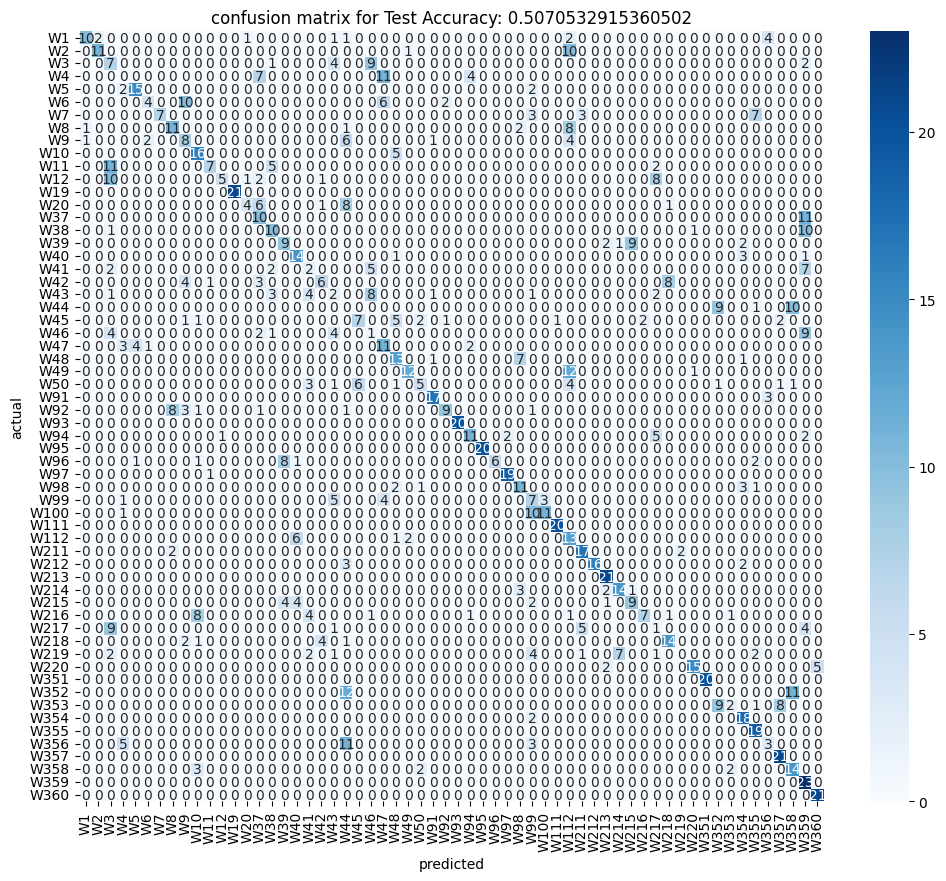

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

print(test_accuracy)
ylabel =['W1','W2','W3','W4','W5','W6','W7','W8','W9','W10','W11','W12','W19','W20','W37','W38','W39','W40','W41','W42','W43','W44','W45','W46','W47','W48','W49','W50','W91','W92','W93','W94','W95','W96','W97','W98','W99','W100','W111','W112','W211','W212','W213','W214','W215','W216','W217','W218','W219','W220','W351','W352','W353','W354','W355','W356','W357','W358','W359','W360']
print(len(ylabel))
# ticklabels=np.unique(y_val_true_classes)
plt.figure(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap='Blues',xticklabels=ylabel,yticklabels=ylabel)
plt.title(f'confusion matrix for Test Accuracy: {test_accuracy}')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

In [10]:








num_folds = 10
# Train the model
kfold = KFold(n_splits=num_folds, shuffle=True)


i = 1

all_accuracies = []
test_accuracies = []
conf_matrixes = []
bestTestAccuracy=0
bestTest=0

for train, test in kfold.split(x_train, y_train):

    input = Input(shape=input_shape)
    bd1 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bn1 = BatchNormalization()(bd1)
    bd11 = Dropout(0.3)(bd1)

    bd2 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bd22 = BatchNormalization()(bd2)

    att = Attention(use_scale=True)([bd2, bd11])

    merged = Concatenate(axis=-1)([bd2, att])

    flat = Flatten()(merged)
    dense = Dense(units=64, activation='silu')(flat)
    dp2 = Dropout(0.3)(dense)
    out = Dense(NO_CLASSES, activation='softmax')(dp2)
    
    model = Model(input, out)
    optimizer = Adam(learning_rate=learning_rate)
    early_stoppage = EarlyStopping(monitor="loss",mode="auto", patience = 5,  restore_best_weights=True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    
    print("---------------fold {} -----------".format(i))
    
    model.fit(x_train[train], y_train[train], epochs=epochs,  batch_size=batch_size, callbacks=[early_stoppage],validation_data=(x_train[test],y_train[test]))

    # Evaluate the model on the validation set
    y_val_pred = model.predict(x_train[test])
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_train[test], axis=1)

        # Calculate accuracy for the fold
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    # all_accuracies.append(test_accuracy)
    all_accuracies.append(test_accuracy)
    # average_accuracy = np.mean(all_accuracies)


    ##avg_acc = all_accuracies/epochs

    print(f'Validation Accuracy Fold {i}: {test_accuracy}')



    # Evaluate the model on the test set
    y_val_pred = model.predict(x_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val, axis=1)
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    if test_accuracy >bestTestAccuracy:
        bestTestAccuracy=test_accuracy
        bestTest=i
    print(f'Test - Accuracy: {test_accuracy}')

    test_accuracies.append(test_accuracy)

    conf_mat = confusion_matrix(y_val_true_classes,y_val_pred_classes)

    conf_matrixes.append(conf_mat)
    i += 1
    


average_accuracy = np.mean(all_accuracies)
print("Average  cross validation accuracy: {average_accuracy}")



average_accuracy = np.mean(test_accuracies)
print("Average test accuracy: {average_accuracy}")


# # Evaluate the model on the test set
# y_val_pred = model.predict(x_val)
# y_val_pred_classes = np.argmax(y_val_pred, axis=1)
# y_val_true_classes = np.argmax(y_val, axis=1)
# test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
# print(f'Test - Accuracy: {test_accuracy}')




---------------fold 1 -----------
Epoch 1/200


W0000 00:00:1703937570.292384  367531 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - ETA: 0s - loss: 3.9760 - accuracy: 0.0472

In [ ]:
print(test_accuracies)
print(np.average(test_accuracies))
print(all_accuracies)
print(np.average(all_accuracies))

In [ ]:
# print(conf_matrixes)

In [ ]:
# average_conf_mat = np.sum(conf_matrixes, axis=0)
# average_conf_mat

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat= conf_matrixes[bestTest-1]
print('test accuracies: ',test_accuracies, 'best:', bestTest-1)
# print ('validation accuracies: ',all_accuracies)
# average_conf_mat = np.mean(conf_matrixes, axis=0)
# for conf_matrix in conf_matrixes:
#     average_conf_mat +=  conf_matrix
# y_val_true_classes,y_val_pred_classes
ylabel =['W1','W2','W3','W4','W5','W6','W7','W8','W9','W10','W11','W12','W19','W20','W37','W38','W39','W40','W41','W42','W43','W44','W45','W46','W47','W48','W49','W50','W91','W92','W93','W94','W95','W96','W97','W98','W99','W100','W111','W112','W211','W212','W213','W214','W215','W216','W217','W218','W219','W220','W351','W352','W353','W354','W355','W356','W357','W358','W359','W360']
print(len(ylabel))
# ticklabels=np.unique(y_val_true_classes)
plt.figure(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap='Blues',xticklabels=ylabel,yticklabels=ylabel)
plt.title(f'confusion matrix for Test data in fold #{bestTest} Accuracy: {test_accuracies[bestTest-1]}')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

plt.savefig(f'HandPose_RightHand_LeftHandFlipped_acc_{bestTest-1}_{test_accuracies[bestTest-1]}.png')

In [ ]:
# print(y_val_pred.shape)
# print(y_val_pred)
# print(y_val_pred[0][10])

# bestTest-1

plt.close

In [ ]:
# y_val_pred = model.predict(x_val)
# print(y_val_pred[0])
# y_val_pred_classes = np.argmax(y_val_pred, axis=1)
# y_val_true_classes = np.argmax(y_val, axis=1)

In [ ]:
print('Hello')

: 